# CSE 572: Lab 12

In this lab, you will practice implementing techniques for dimensionality reduction using principal component analysis.

To execute and make changes to this notebook, click File > Save a copy to save your own version in your Google Drive or Github. Read the step-by-step instructions below carefully. To execute the code, click on each cell below and press the SHIFT-ENTER keys simultaneously or by clicking the Play button. 

When you finish executing all code/exercises, save your notebook then download a copy (.ipynb file). Submit the following **three** things:
1. a link to your Colab notebook,
2. the .ipynb file, and
3. a pdf of the executed notebook on Canvas.

To generate a pdf of the notebook, click File > Print > Save as PDF.

## Principal Component Analysis

Principal component analysis (PCA) is a classical method for reducing the dimensionality (number of attributes) in the data by projecting the data from its original high-dimensional space into a lower-dimensional space. 

The new attributes (also known as principal components) created by PCA have the following properties: 
1. they are linear combinations of the original attributes, 
2. they are orthogonal (perpendicular) to each other, and 
3. they capture the maximum amount of variation in the data.

In this lab, we will apply PCA to an image dataset to explore the patterns in the data. We will then use PCA to reduce the number of dimensions and use the transformed data as the input attributes to a face identification classifier. 

### Load the dataset

We will use a preprocessed subset of the “Labeled Faces in the Wild” (LFW) dataset, which you can read more about [here](http://vis-www.cs.umass.edu/lfw/).

In [59]:
from sklearn.datasets import fetch_lfw_people

lfw_people = fetch_lfw_people(min_faces_per_person=70)

# data attribute gives the data matrix with the image dimension flattened
X = lfw_people.data
print('Num samples: {}'.format(X.shape[0]))
print('Num features: {}'.format(X.shape[1]))

# images attribute gives the unflattened image dimension
print('Image dimensions: {} x {}'.format(lfw_people.images.shape[1], lfw_people.images.shape[2]))

# the label to predict is the id of the person
y = lfw_people.target
# target_names attribute tells us the name of the person associated with each id
target_names = lfw_people.target_names
n_classes = target_names.shape[0]
print('Num classes: {}'.format(n_classes))
print('Class names:', target_names)

Num samples: 1288
Num features: 2914
Image dimensions: 62 x 47
Num classes: 7
Class names: ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']


The dataset has 1,288 images of the faces of 7 different people. How many instances of each person are in the dataset? Write the code to print the number of samples from each class below. (Include both the ID and name of each class in your print statements.)

In [60]:
# YOUR CODE HERE
import pandas as pd
targetDF = pd.DataFrame(y).value_counts()
targetDF = targetDF.sort_index()

for i, count in enumerate(targetDF):
  print("Class: {} having Id: {:3d} has {:3d} number of samples.".format(target_names[i], i, count))

Class: Ariel Sharon having Id:   0 has  77 number of samples.
Class: Colin Powell having Id:   1 has 236 number of samples.
Class: Donald Rumsfeld having Id:   2 has 121 number of samples.
Class: George W Bush having Id:   3 has 530 number of samples.
Class: Gerhard Schroeder having Id:   4 has 109 number of samples.
Class: Hugo Chavez having Id:   5 has  71 number of samples.
Class: Tony Blair having Id:   6 has 144 number of samples.


To get an idea of what is in our dataset, we visualize a random face from each class below. (Note: You can run this cell many times to see different random examples.)

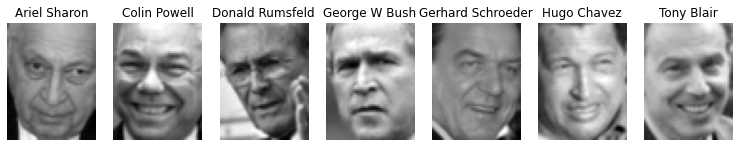

In [61]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=n_classes, figsize=(13,6))

for i in range(n_classes):
    rand_ind = np.random.randint(0, y[y==i].shape[0])
    axes[i].imshow(lfw_people.images[y==i][rand_ind], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(target_names[i])

Next, we will split the data into training and test subsets, using 30\% of the data for testing.

In [62]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

Next we standardize the data so that the mean of all attributes is 0. Instead of doing this manually as in previous labs, below we demonstrate how to use the StandardScaler() object in scikit-learn to standardize the data. We fit the scaler to the training data and apply it to both the training and test data.

In [63]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### PCA

Now we can find the eigenvectors of the data which we will use to transform the data into a new set of features that maximizes variance in the dataset. 

In [64]:
from sklearn.decomposition import PCA

n_components = 10

pca = PCA(n_components=n_components).fit(X_train)

The principal components computed for the dataset are stored in the `components_` attribute of the trained model. These components can be reshaped to be the dimension of the original images and then plotted as an image. The principal components or eigenvectors of face datasets are commonly called "eigenfaces".

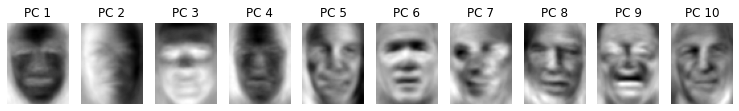

In [65]:
_, h, w = lfw_people.images.shape

eigenfaces = pca.components_.reshape((n_components, h, w))

fig, axes = plt.subplots(ncols=n_components, figsize=(13,6))

for i in range(n_components):
    axes[i].imshow(eigenfaces[i], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title('PC {}'.format(i+1))

The percentage of variance explained by each of the components is stored in the `explained_variance_ratio_` attribute of the trained model. For our example with 10 PCs above, we can print the percentage of variance explained by each PC and by all of the chosen PCs combined as follows:

In [66]:
for i in range(n_components):
    print('Percentage of variance explained by PC {}: {}'.format(i+1, pca.explained_variance_ratio_[i]))
    
print('Total variance explained by 10 PCs: {}'.format(np.sum(pca.explained_variance_ratio_)))

Percentage of variance explained by PC 1: 0.23413504660129547
Percentage of variance explained by PC 2: 0.1557781845331192
Percentage of variance explained by PC 3: 0.07284828275442123
Percentage of variance explained by PC 4: 0.0513952262699604
Percentage of variance explained by PC 5: 0.033575236797332764
Percentage of variance explained by PC 6: 0.02732495591044426
Percentage of variance explained by PC 7: 0.020755823701620102
Percentage of variance explained by PC 8: 0.018149426206946373
Percentage of variance explained by PC 9: 0.01751403510570526
Percentage of variance explained by PC 10: 0.01572388969361782
Total variance explained by 10 PCs: 0.6472001075744629


In the cell below, create a plot that shows the number of principal components on the x axis and the total variance explained by that number of principal components on the y axis for $n_{components} \in [1, 10]$. Your plot should look like the following:

![image.png](https://drive.google.com/uc?id=19lr_KE0vRIifpz0kb_gcjOO4tZP44-kH)

[0.23413505, 0.38991323, 0.46276152, 0.51415676, 0.547732, 0.57505697, 0.5958128, 0.61396223, 0.6314763, 0.64720017]


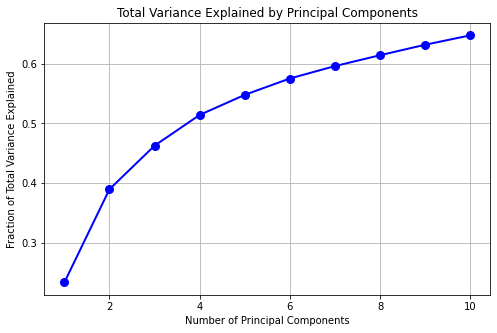

In [67]:
# YOUR CODE HERE

pcaResults=[]
sumOfPCAs=np.sum(pca.explained_variance_ratio_)

pcaResults.append((pca.explained_variance_ratio_[0]))

for i in range(1,n_components):
     pcaResults.append(pca.explained_variance_ratio_[i]+pcaResults[i-1])

print(pcaResults)
plt.figure(figsize=(8, 5))
plt.plot([1,2,3,4,5,6,7,8,9,10], pcaResults, '-bo', linewidth=2, markersize=8)

# Add axis labels and a title
plt.xlabel('Number of Principal Components')
plt.ylabel('Fraction of Total Variance Explained')
plt.title('Total Variance Explained by Principal Components')

# Add a grid to the plot
plt.grid(True)

# Show the plot
plt.show()

**Question 1: What is the fraction of the total variance explained by PC1 + PC2?**

**Answer:**

YOUR ANSWER HERE \
PC1 + PC2 is 0.38991317153 \
Fraction of Total is = 0.38991317153 / 0.6472001671791077 \
            = 0.60246148147

We can use our PCA model (i.e., the principal component vectors found in our data) to transform our dataset into the new reduced-dimensional space. This is done in the below code using the `transform()` function.

In [68]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

We now have a 10-dimensional version of our dataset. This is much smaller than the original 2914 dimensions! We can visualize the data in the first two component dimensions (which captures most of the variance in the data) using a scatter plot, colored by class to see the differences between classes.

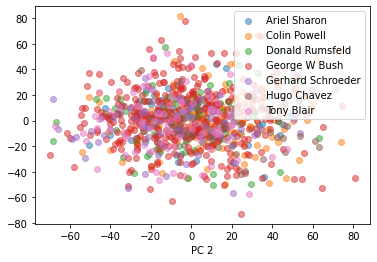

In [69]:
fig, ax = plt.subplots(1)

for i in range(n_classes):
    ax.scatter(X_train_pca[y_train==i][:,0], X_train_pca[y_train==i][:,1], label=target_names[i], alpha=0.5)
    
ax.set_xlabel('PC 1')
ax.set_xlabel('PC 2')
ax.legend()

This is a difficult dataset to classify since many of the faces look similar to each other, but we can see some structure in the data here. For example, there seem to be many small local clusters of the same class where the nearest neighbors of an instance are commonly the same class.

### SVM classifier with PCA

Now that we've reduced the dimensionality of our dataset from 2914 to 10, we can use these new features as our inputs for classification. In this example, we'll use a Support Vector Machine (SVM) classifier. In the cell below, train an SVM with `C=10000` and `kernel='rbf'`.

In [70]:
from sklearn.svm import SVC

# YOUR CODE HERE

model = SVC(C = 10000, kernel = "rbf")

model.fit(X_train_pca, y_train)

SVC(C=10000)

In the cell below, use the trained model to make predictions for the test set.

In [71]:
y_pred = model.predict(X_test_pca)

The next cell shows how we can use the `classification_report()` function in sklearn to print several metrics computed for the test set. 

In [72]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.17      0.22      0.19        18
     Colin Powell       0.44      0.55      0.49        69
  Donald Rumsfeld       0.27      0.38      0.32        34
    George W Bush       0.70      0.63      0.66       166
Gerhard Schroeder       0.31      0.29      0.30        31
      Hugo Chavez       0.33      0.26      0.29        19
       Tony Blair       0.33      0.24      0.28        50

         accuracy                           0.48       387
        macro avg       0.36      0.37      0.36       387
     weighted avg       0.49      0.48      0.48       387



We can also use the `ConfusionMatrixDisplay` object to visualize the confusion matrix for the test set predictions.

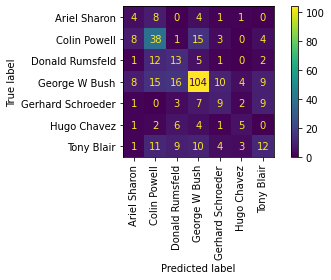

In [73]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(
    model, X_test_pca, y_test, display_labels=target_names, xticks_rotation="vertical"
)

plt.tight_layout()
plt.show()

**Question 2: For which classes did the model perform best?**

**Answer:**


George W Bush

**Question 3: For which classes did the model perform worst?**

**Answer:**


Ariel Sharon

**Question 4: What other class(es) did the model most frequently misclassify Ariel Sharon samples as?**

**Answer:**


Colin Powell and George W Bush